In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
from collections import Counter

import wandb
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.transforms.functional import to_tensor
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

import lightning.pytorch as pl

## Data Exploration

In [2]:
data_path = Path('../data')

dataset = MNIST(
    root=data_path,
    train=True,
    download=True,
)

dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train

<PIL.Image.Image image mode=L size=28x28 at 0x7FCEA568C5E0> (0, 255)


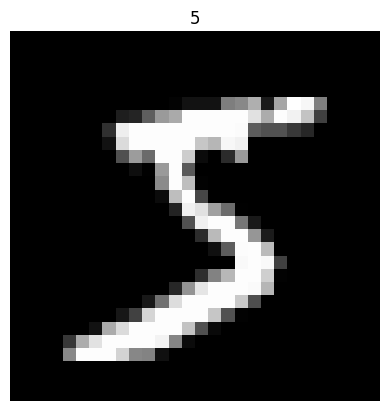

In [3]:
## Single data point
for img, label in dataset:
    print(img, img.getextrema())
    plt.imshow(img, cmap='gray')
    plt.axis(False)
    plt.title(label)

    plt.show()
    break

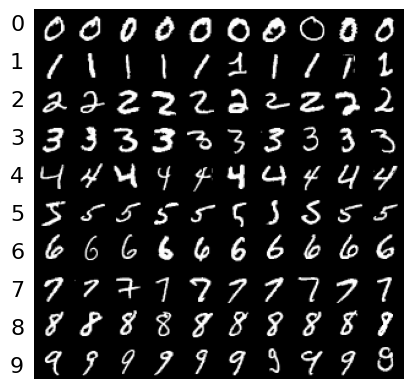

In [4]:
## A grid of images from each class

dataset.transform = Compose([
    ToTensor()
])

num_classes = 10
images_per_class = 10

# Create a list to store the images for each class
class_images = [[] for _ in range(num_classes)]

# Iterate over the dataset and collect the first `images_per_class` images for each class
for image, label in dataset:
    if len(class_images[label]) < images_per_class:
        class_images[label].append(image)
    if all(len(images) == images_per_class for images in class_images):
        break

# Create a single grid of images with one row per class
grid = make_grid([img for images in class_images for img in images], nrow=images_per_class)
plt.imshow(grid.permute(1, 2, 0))

# Add labels for each class at the start of the row
for i in range(num_classes):
    plt.text(-20, i * 31 + 17, str(i), fontsize=16)

plt.axis(False)
plt.show()

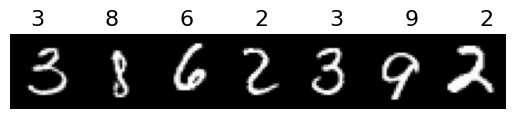

In [5]:
## Random images

dataloader = DataLoader(dataset, batch_size=7, shuffle=True)

for images, labels in dataloader:
    grid = make_grid(images)
    plt.imshow(grid.permute(1, 2, 0))

    # Add labels for the images
    for i, label in enumerate(labels):
        plt.text(i * 32 + 8, -4, str(label.item()), fontsize=16)

    plt.axis(False)
    plt.show()
    break

In [6]:
## Class distributions

# Get the labels for all images in the dataset
labels = [label for _, label in dataset]

# Count the number of occurrences of each label
label_counts = Counter(labels)
label_counts_array = np.array(list(label_counts.values()))

Mean: 6000.0, STD: 322.082908581005


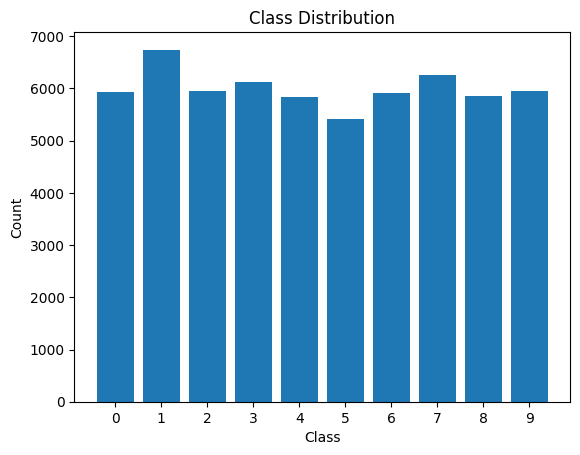

In [7]:
print(f"Mean: {label_counts_array.mean()}, STD: {label_counts_array.std()}")

# Plot the distribution of labels
plt.bar(label_counts.keys(), label_counts.values())
plt.xticks(range(10))
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [8]:
dataset.transform = Compose([
    ToTensor(),
    Normalize(0.5, 0.5)
])

dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train

In [9]:
train_size = int(0.7 * len(dataset))
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, num_workers=8)

In [11]:
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


# Training

In [19]:
class LeNet5(pl.LightningModule):
    def __init__(self, lr=0.001):
        super().__init__()
        self.lr = lr
        self.model = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(12, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU(),

            nn.Linear(512, 84),
            nn.ReLU(),

            nn.Linear(84, 10)
        )

        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("train/loss", loss)

        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        loss = nn.functional.cross_entropy(y_pred, y)

        self.log("val/loss", loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)

        return optimizer

model = LeNet5()

In [20]:
logger = pl.loggers.WandbLogger(project='digits')

trainer = pl.Trainer(limit_train_batches=100, max_epochs=10, logger=logger)
trainer.fit(model, train_dataloader, valid_dataloader)

wandb.finish()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 180 K 
-------------------------------------
180 K     Trainable params
0         Non-trainable params
180 K     Total params
0.723     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


epoch,▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇███
train/loss,█▄▄▂▃▂▂▃▁▂▂▁▂▁▂▂▃▁▂▂
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇███
val/loss,█▅▃▃▃▂▂▂▁▁
epoch,9
train/loss,0.06622
trainer/global_step,999
val/loss,0.06875


In [19]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [21]:
y_true, y_pred, target_names = test(valid_dataloader, model, loss_fn)

Test set: Average loss: 0.449, Accuracy: 96.828%


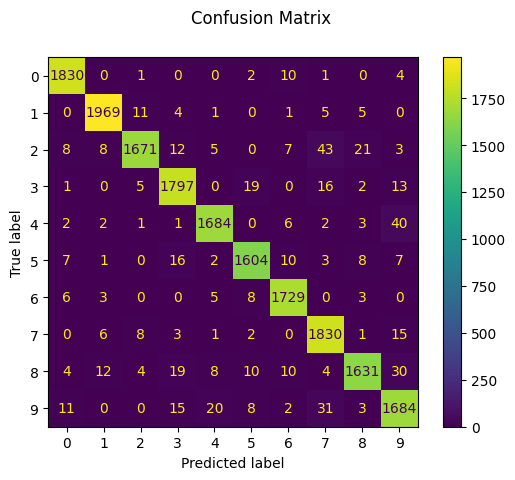

In [22]:
disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

In [23]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1848
           1       0.98      0.99      0.99      1996
           2       0.98      0.94      0.96      1778
           3       0.96      0.97      0.97      1853
           4       0.98      0.97      0.97      1741
           5       0.97      0.97      0.97      1658
           6       0.97      0.99      0.98      1754
           7       0.95      0.98      0.96      1866
           8       0.97      0.94      0.96      1732
           9       0.94      0.95      0.94      1774

    accuracy                           0.97     18000
   macro avg       0.97      0.97      0.97     18000
weighted avg       0.97      0.97      0.97     18000



## Save model

In [21]:
models_path = Path('../models/')
LeNet5_model_path = models_path / "LeNet5/LeNet5.pth"

In [22]:
torch.save(model.state_dict(), LeNet5_model_path)
print(f"Saved PyTorch Model State to {LeNet5_model_path}")

Saved PyTorch Model State to ../models/LeNet5/LeNet5.pth
